<a href="https://www.kaggle.com/code/asmaamohamedashmawy/erg-pro?scriptVersionId=178611189" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import shutil

## importing our dataset (ERG) 

In [62]:
# Read the Excel file into a Pandas DataFrame
SR = pd.read_excel("/kaggle/input/electroretinogram/01 Appendix 1.xlsx", sheet_name='Scotopic 2.0 ERG Response')
PR = pd.read_excel("/kaggle/input/electroretinogram/01 Appendix 1.xlsx", sheet_name='Photopic 2.0 ERG Response')
MR = pd.read_excel("/kaggle/input/electroretinogram/01 Appendix 1.xlsx", sheet_name='Maximum 2.0 ERG Response')


/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)
/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)
/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)


In [63]:
MR.drop(columns = MR.columns[124:], inplace=True)
PR.drop(columns = PR.columns[110:], inplace=True)
SR.drop(columns = SR.columns[80:], inplace=True)

In [64]:
mapping = {'The functional activity of the central and peripheral parts of the retina in both eyes is preserved.':'abnormal','Pupil is narrow.':'abnormal','The functional activity of the central and peripheral parts of the retina in both eyes is preserved.':'abnormal','Registration of ERG with a narrow pupil.':'abnormal','Registration of the ERG of a narrow pupil from the skin of the eyelid.':'abnormal','ERG pupil is narrow.':'abnormal','Registration of ERG from the skin of the eyelid, the pupil is narrow.':'abnormal','Registration of ERG with a narrow pupil from the skin of the eyelid.':'abnormal','The functional activity of the central and peripheral parts of the retina in both eyes is preserved.':'abnormal','High level of interference due to increased physical activity of the child.':'abnormal','The functional activity of the retina is preserved.':'normal','The functional activity of the retina at the OU is preserved.': 'normal','The functional activity of the retina is preserved.':'normal','No negative dynamics compared to previous data.': 'normal','The functional activity of the retina is preserved.': 'normal','The functional activity of the central and peripheral parts of the retina in both eyes is preserved.':'normal','No diagnosis.': 'normal','The signal is within normal limits.': 'normal','The functional activity of the retina is preserved, corresponds to the age norm symmetrically on the OU.': 'normal','The functional activity of the retina in both eyes is preserved.': 'normal','The amplitude-time characteristics of the EP in a homogeneous field correspond to the norm.': 'normal','The functional activity of the retina in both eyes is preserved. High level of interference due to increased motor activity of the child.': 'normal','The functional activity of the retina at the OU is preserved. No macular pathology was revealed.': 'The functional activity of the central and peripheral parts of the retina in both eyes is preserved.','No diagnosis.': 'normal','Electrogenesis of the central parts of the retina normally does not exclude dystrophy of the rod apparatus of the retina with a favorable prognosis of the course.': 'normal','The functional activity of the central and peripheral parts of the retina in both eyes is preserved.':'normal','Correct configuration potentials. The amplitude-time characteristics of the a- and b-waves of the rod maximal and cone responses correspond to the norm.': 'normal', 'Perhaps the reason for the violation of twilight vision is hypovitaminosis.': 'normal' ,'Hereditary cone dystrophy.': 'abnormal', 
          'Retinal rod dystrophy with a favorable prognosis is not excluded.': 'abnormal','Decreased the amplitude of the b-wave of the maximum and rod responses.': 'abnormal','Electrogenesis of the peripheral parts of the retina in the norm, the electrogenesis of the central parts of the retina is sharply impaired. Perhaps there is hereditary cone dystrophy.': 'abnormal','Reduced functional activity of the retina changes at the level of the outer and middle layers in the central and peripheral parts.': 'abnormal','Combination of congenital myopia and congenital hemeralopia.': 'abnormal','OD - outside and in the upper section of the old chorioretinal focus.': 'abnormal','Rod dystrophy of the retina with a favorable prognosis.': 'abnormal','The functional activity of the peripheral parts of the retina is normal, the functional activity of the central parts of the retina is moderately reduced.': 'abnormal','Hereditary rod dystrophy of the retina is possible.': 'abnormal','Central dystrophy with cone-rod dysfunction is possible.': 'abnormal','The preservation of the retinal electrogenesis from its central and peripheral parts, as well as the preservation of conductivity along the pathways of the visual analyzer, can be expected to improve visual functions after restoration of the transparency of the OS optical media.': 'abnormal','Retinal cone-rod dystrophy.': 'abnormal', 'Pronounced organic changes in the outer and inner layers in the center and periphery of the retina.': 'abnormal', 'Moderate pronounced change in the outer and middle layers of the central and peripheral parts of the retina of the right eye.': 'abnormal', 'Decrease in electrogenesis and functional activity of the retina.': 'abnormal', 'Retinal rod dystrophy with a favorable prognosis is possible.': 'abnormal', 'Signs of moderate disturbances in the electrogenesis of the central parts of the retina in the left eye.': 'abnormal', 'OU - maximum ERG b-wave reduction. Central dystrophy with cone-rod dysfunction is possible.': 'abnormal', 'The functional activity of the retina of the left eye is protected by a moderate decrease in the functional activity of the retina of the right eye.': 'abnormal', 'The functional activity of the retina OD is preserved on the OS and is moderately reduced (changes at the level of the outer and middle layers of the retina in the central and peripheral regions).': 'abnormal', 'The functional activity of the central parts of the retina is moderately reduced.': 'abnormal', 'Changes in the bioelectrical activity of the retina against the background of high myopia.': 'abnormal', 'Hereditary rod dystrophy of the retina is not excluded.': 'abnormal', 'Decrease of the B-wave amplitude by 3 times on OD, 2 times on OS.': 'abnormal', 'OU - a pronounced decrease in the b-wave of the maximum response is reduced.': 'abnormal'}
MR.replace(mapping, inplace=True)
PR.replace(mapping, inplace=True)
SR.replace(mapping, inplace=True)

In [65]:
patiant_Diagnosis_M = MR.iloc[4 , :122].tolist()
patiant_Diagnosis_P = PR.iloc[4 , :106].tolist()
patiant_Diagnosis_S = SR.iloc[4 , :74].tolist()

In [66]:
patiant_id_M = MR.iloc[3 , :122].tolist()
patiant_id_P = PR.iloc[3 , :106].tolist() #20 
patiant_id_S = SR.iloc[3 , :74].tolist()

In [67]:
M_R =['MR']*122
P_R =['PR']*106
S_R =['SR']*74

In [68]:
len(patiant_Diagnosis_M+patiant_Diagnosis_P+patiant_Diagnosis_S)
len(patiant_id_P)

106

In [69]:
# Create a dictionary from the two lists
dict = {'Patient_id': patiant_id_M+patiant_id_P+patiant_id_S, 'Label': patiant_Diagnosis_M+patiant_Diagnosis_P+patiant_Diagnosis_S ,'signal_type':M_R+P_R+S_R}

# Create a new dataframe from the dictionary
df = pd.DataFrame(dict)
#df=df.sample(frac=1).reset_index(drop=True)

In [70]:
filtered_df = df[df['Label'] == 'Diagnosis']

In [71]:
df = df[~(df['Label'] == 'Diagnosis')] #the negation operator ~ in front of the boolean mask, we invert the mask to select the rows that do not contain the specific value.
df=df.reset_index(drop=True)
df.groupby(['Label']).count()

,Patient_id,signal_type
Label,,
The functional activity of the central and peripheral parts of the retina in both eyes is preserved.,2,2
abnormal,107,107
normal,190,190


In [72]:
!mkdir signals
!mkdir augmented_images

mkdir: cannot create directory 'signals': File exists
mkdir: cannot create directory 'augmented_images': File exists


In [73]:
def repeat_val(x):
    if x<200 : k=4 
    elif x>200 and x<=400 : k=3 
    elif x>400 and x<=550 : k=2 
    return k  

## Transform the signal by Ricker wavelet (mexican hat)

In [74]:
signal_PR=[]
signal_PR_id=[]
path='/kaggle/working/signals/'
for j in range(0,2):
    for i in range (1,106):
        signal = np.array(PR.iloc[21: ,i].tolist())
        signal_values = signal[np.logical_not(np.isnan(signal))]
        k = repeat_val(len(signal_values))

        signal_values = np.tile(signal_values.tolist()+[0]*30,k-j)
        
        coefficients, frequencies = pywt.cwt(signal_values, scales=np.arange(1, 128), wavelet='mexh')
        plt.figure(figsize=(5.12, 5.12))
        plt.imshow(abs(coefficients) ** 2, cmap='gray', aspect='auto',vmax=abs(coefficients).max(), vmin=-abs(coefficients).min())
        plt.axis('off')
        plt.savefig(os.path.join(path, f'PR_{i}_{j}_f.png'))
        plt.close()
        signal_PR.append(path + f'PR_{i}_{j}_f.png')
        signal_PR_id.append(f'PR_{i}_{j}_f')
    

In [75]:
signal_MR=[]
signal_MR_id=[]
for j in range(0,2):
    for i in range (1,122):
        signal = np.array(MR.iloc[22: ,i].tolist())  
        signal_values = signal[np.logical_not(np.isnan(signal))]
        k = repeat_val(len(signal_values))

        signal_values = np.tile(signal_values.tolist()+[0]*30,k-j)
        
        coefficients, frequencies = pywt.cwt(signal_values, scales=np.arange(1, 128), wavelet='mexh')
        plt.figure(figsize=(5.12, 5.12))
        plt.imshow(abs(coefficients) ** 2, cmap='gray', aspect='auto',vmax=abs(coefficients).max(), vmin=-abs(coefficients).min())
        plt.axis('off')
        plt.savefig(os.path.join(path, f'MR_{i}_{j}_f.png'))
        plt.close()
        signal_MR.append(path + f'MR_{i}_{j}_f.png')
        signal_MR_id.append(f'MR_{i}_{j}_f')

In [76]:
signal_SR=[]
signal_SR_id=[]
for j in range(0,2):
    for i in range (1,74):
        signal = np.array(SR.iloc[21: ,i].tolist())  
        signal_values = signal[np.logical_not(np.isnan(signal))]
        k = repeat_val(len(signal_values))

        signal_values = np.tile(signal_values.tolist()+[0]*0,k-j)
          
        coefficients, frequencies = pywt.cwt(signal_values, scales=np.arange(1, 128), wavelet='mexh')
        plt.figure(figsize=(5.12, 5.12))
        plt.imshow(abs(coefficients) ** 2, cmap='gray', aspect='auto',vmax=abs(coefficients).max(), vmin=-abs(coefficients).min())
        plt.axis('off')
        plt.savefig(os.path.join(path, f'SR_{i}_{j}_f.png'))
        plt.close()
        signal_SR.append(path + f'SR_{i}_{j}_f.png')
        signal_SR_id.append(f'SR_{i}_{j}_f')


## the final data frame

In [77]:
df = pd.DataFrame({'Label': np.tile(df['Label'],2)})
df['img_Path'] = signal_MR+signal_PR+signal_SR
df['img_id'] = signal_MR_id+signal_PR_id+signal_SR_id
df.groupby(['Label']).count()

,img_Path,img_id
Label,,
The functional activity of the central and peripheral parts of the retina in both eyes is preserved.,4,4
abnormal,214,214
normal,380,380


In [79]:
df.to_csv('data1.csv')

In [81]:
mapping = {'normal': int(0), 'abnormal': int(1)}  
df.replace(mapping, inplace=True)
df = df.reset_index(drop=True)

In [82]:
droped_normal = df.query('Label == 0').sample(n=150)
df.drop(droped_normal.index, inplace=True)
df=df.reset_index(drop=True)

In [84]:
df.groupby(['Label']).count()

,img_Path,img_id
Label,,
0,230,230
1,214,214
The functional activity of the central and peripheral parts of the retina in both eyes is preserved.,4,4


In [85]:
df.to_csv('Scalogram_grayscale_images.csv')
droped_normal.to_csv('test_normal.csv')

In [86]:
augmented_folder_path='/kaggle/working/augmented_images/'
lables_aug=[]
paths_aug=[]
id_aug=[]
# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

labels = ['rotated','sheered', 'zoomed', 'horizontal_flipped' ,'brightness_changed']

for n in range (len(df.img_Path)):
    # Loading a sample image 
    img = load_img(df.img_Path[n]) 
    # Converting the input sample image to an array
    x = img_to_array(img)
    # Reshaping the input image
    x = x.reshape((1, ) + x.shape)
    j=0
    # Loop through the 5 augmented images and save each image with its corresponding label
    for i, batch in enumerate(datagen.flow(x, batch_size=1,save_format='png')):
        # Get the augmented image array
        augmented_image = batch[0]
        # Get the corresponding label
        label = labels[j]
        j+=1
        # Save the augmented image with its corresponding label
        img = array_to_img(augmented_image)
        img.save(os.path.join(augmented_folder_path, f'{df.img_id[n]}_{label}.png'))
        paths_aug.append(f'{augmented_folder_path}/{df.img_id[n]}_{label}.png')  
        lables_aug.append(df.Label[n])
        id_aug.append(f'{df.img_id[n]}_{label}')
        if j==5:
            break  

In [87]:
# Create a dictionary from the two lists
dict = {'img_Path': paths_aug+list(df.img_Path), 'Label': lables_aug+list(df.Label), 'img_id': id_aug+list(df.img_id) }

# Create a new dataframe from the dictionary
final = pd.DataFrame(dict)
#final=final.sample(frac=1).reset_index(drop=True)

In [88]:
final.to_csv('Scalogram_grayscale_augumented_images.csv')

In [89]:
shutil.make_archive('/kaggle/working/output', 'zip', '/kaggle/working/')

'/kaggle/working/output.zip'

In [90]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CSV Data
df_aug = final
#df_aug = df_aug.drop('Unnamed: 0', axis=1)

# Define image dimensions and batch size
img_height = 224
img_width = 224
BATCH_SIZE = 32

# Filter out a specific label and ensure labels are strings
df_aug = df_aug[df_aug['Label'] != 'The functional activity of the central and peripheral parts of the retina in both eyes is preserved.'].reset_index(drop=True)
df_aug['Label'] = df_aug['Label'].astype(str)

# Generate Image Paths
img_Path = []
for i in range(len(df_aug.img_id)):
    if i < 2220:
        img_Path.append(f'/kaggle/working/augmented_images/{df_aug.img_id[i]}.png')
    else:
        img_Path.append(f'/kaggle/working/signals/{df_aug.img_id[i]}.png')
df_aug['img_Path'] = img_Path

# Assuming train_df_aug, valid_df_aug, and test_df_aug are already defined
# Here we create them for completeness
image_train, image_test, label_train, label_test = train_test_split(
    df_aug.img_Path, df_aug.Label, test_size=0.2, random_state=42, stratify=df_aug['Label']
)
image_valid, image_Test, label_valid, label_Test = train_test_split(
    image_test, label_test, test_size=0.5, random_state=42, stratify=label_test
)

train_df_aug = pd.DataFrame({'image_id': image_train, 'label': label_train}).reset_index(drop=True)
valid_df_aug = pd.DataFrame({'image_id': image_valid, 'label': label_valid}).reset_index(drop=True)
test_df_aug = pd.DataFrame({'image_id': image_Test, 'label': label_Test}).reset_index(drop=True)

# Create ImageDataGenerator Instances
train_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=train_df_aug,
    directory='/kaggle/working/',  # Ensure this is an empty string since paths are absolute
    x_col='image_id',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Change to 'categorical' for multi-class classification
)
valid_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=valid_df_aug,
    directory='/kaggle/working/',  # Ensure this is an empty string since paths are absolute
    x_col='image_id',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Change to 'categorical' for multi-class classification
)
test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=test_df_aug,
    directory='/kaggle/working/',  # Ensure this is an empty string since paths are absolute
    x_col='image_id',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Change to 'categorical' for multi-class classification
)


Found 2131 validated image filenames belonging to 2 classes.
Found 266 validated image filenames belonging to 2 classes.
Found 267 validated image filenames belonging to 2 classes.


In [91]:
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy

def identity_block(X, f, filters, stage, block):
    # Helper function to implement the identity block
    # X: input tensor
    # f: integer, shape of the middle CONV's window for the main path
    # filters: list of integers, the filters of the 3 CONV layers at the main path
    # stage: integer, used to name the layers, depending on their position in the network
    # block: string/character, used to name the layers, depending on their position in the network

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = 'res' + str(stage) + block + '_branch2a', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = 'res' + str(stage) + block + '_branch2b', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = 'res' + str(stage) + block + '_branch2c', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # Helper function to implement the convolutional block
    # X: input tensor
    # f: integer, shape of the middle CONV's window for the main path
    # filters: list of integers, the filters of the 3 CONV layers at the main path
    # stage: integer, used to name the layers, depending on their position in the network
    # block: string/character, used to name the layers, depending on their position in the network
    # s: Integer, specifying the stride to be used

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = 'res' + str(stage) + block + '_branch2a', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = 'res' + str(stage) + block + '_branch2b', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = 'res' + str(stage) + block + '_branch2c', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch2c')(X)

    # Shortcut Path
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = 'res' + str(stage) + block + '_branch1', kernel_initializer = 'he_normal')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn' + str(stage) + block + '_branch1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

# Define the model input and initial convolutional layer
input_shape = (224, 224, 3)
X_input = Input(input_shape)
X = ZeroPadding2D((3, 3))(X_input)
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = 'he_normal')(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

# Stage 3-5 (Add more blocks as needed)

# Average Pooling
X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

classes = 1
# Output layer
X = Flatten()(X)
X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = 'he_normal')(X)

# Create model
model = Model(inputs = X_input, outputs = X, name='ResNet50')

# Compile model (Add your optimizer, loss, and metrics)
model.compile(optimizer='adam', loss= BinaryCrossentropy(), metrics=['accuracy'])

# Model summary
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 112, 112,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 112, 112,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 55, 55,    │          0 │ activation_10[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 55, 55,    │      4,160 │ max_pooling2d_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 55, 55,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 55, 55,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 55, 55,    │     36,928 │ activation_11[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 55, 55,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 55, 55,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 55, 55,    │     16,640 │ activation_12[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 55, 55,    │     16,640 │ max_pooling2d_1[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 55, 55,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 55, 55,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 55, 55,    │          0 │ bn2a_branch2c[0]

 Total params: 430,465 (1.64 MB)

 Trainable params: 427,521 (1.63 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [92]:
# Assuming X_train_images and y_train_categorical are your training data and labels
# Define other parameters like batch_size, epochs, etc.
# Fit the model to the training data
model.fit(train_generator, epochs=10,validation_data = valid_generator, verbose = 2 )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 - 29s - 427ms/step - accuracy: 0.5162 - loss: 7.8397 - val_accuracy: 0.5075 - val_loss: 1.3803
Epoch 2/10
67/67 - 13s - 191ms/step - accuracy: 0.5753 - loss: 1.5457 - val_accuracy: 0.5564 - val_loss: 0.8288
Epoch 3/10
67/67 - 13s - 195ms/step - accuracy: 0.6222 - loss: 1.1468 - val_accuracy: 0.5602 - val_loss: 0.7875
Epoch 4/10
67/67 - 13s - 193ms/step - accuracy: 0.7597 - loss: 0.5484 - val_accuracy: 0.5526 - val_loss: 0.7725
Epoch 5/10
67/67 - 13s - 194ms/step - accuracy: 0.7963 - loss: 0.4568 - val_accuracy: 0.5489 - val_loss: 1.1358
Epoch 6/10
67/67 - 13s - 192ms/step - accuracy: 0.8639 - loss: 0.3230 - val_accuracy: 0.5940 - val_loss: 0.8442
Epoch 7/10
67/67 - 21s - 307ms/step - accuracy: 0.9507 - loss: 0.1508 - val_accuracy: 0.5414 - val_loss: 1.2695
Epoch 8/10
67/67 - 13s - 192ms/step - accuracy: 0.9474 - loss: 0.1470 - val_accuracy: 0.5827 - val_loss: 1.1919
Epoch 9/10
67/67 - 13s - 193ms/step - accuracy: 0.8677 - loss: 0.3430 - val_accuracy: 0.5564 - val_loss: 2.1276
Epo

In [93]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [94]:
y_pred_ = model.predict(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step


In [95]:
y_pred_ = model.predict(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [99]:
y_pred = np.round(y_pred_).flatten()
y_true = np.array(test_df_aug.label,int)

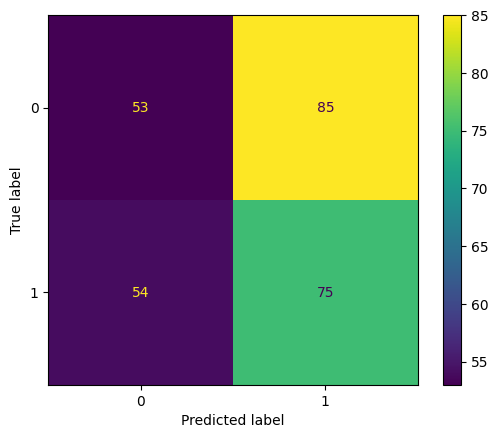

In [100]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [101]:
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
recall = recall_score(y_true, y_pred)
print(f"Recall (Sensitivity): {recall:.4f}")
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f"Specificity: {specificity:.4f}")

Precision: 0.4688
Recall (Sensitivity): 0.5814
F1 Score: 0.5190
Balanced Accuracy: 0.4827
Specificity: 0.3841


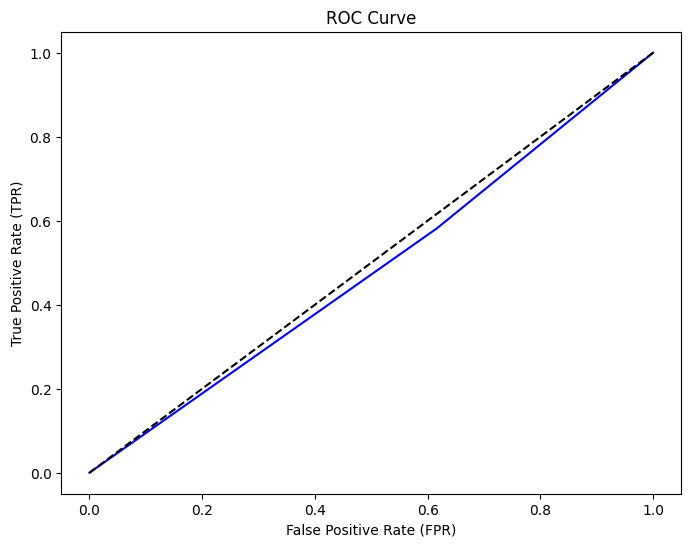

In [102]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
# Create ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Save the entire model to a HDF5 file
#model.save('resnet50_model.h5')